# Anomaly Detection in an RTGS System

In this analysis, we would like to implement an anomaly detection model in a simulated RTGS transactions.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch

from torch import nn, optim
from datetime import datetime, timedelta

## Synthetic Data Generation

In this section, we focus on generating payments data to reflect on an RTGS system. We leverage the algorithm described by Soramaki and Cook (2013) to create a network of simulated payment transactions consisting of multiple banks. Based on the generated data, we can further examine the network using several metrics. Those metrics can be used to investigate the similarity between generated data and the actual condition on which we try to mimic. In this analysis, some parameters are set up to reflect the condition in Indonesian banking landscape.

### Defining function for creating random payments

The `generate_payment_data` function simulates transaction data within a network by initializing a directed graph with `n` nodes and a set of parameters that control the transaction dynamics. It assigns nodes to groups with predefined proportions and transaction shares, influencing how transaction values are calculated. The function generates transactions based on preferential attachment, meaning nodes that transact more frequently are more likely to participate in future transactions. Transactions can include self-transactions if enabled. The output includes both a graph representing the network of transactions and a detailed dataframe with transaction timestamps and values.

In [2]:
#Simulating Payments
def generate_payment_data(n, m, alpha, n0=10, seed=123, total_transactions=45000, date=None, allow_self_loops=False,
                          proportions=None, transaction_shares=None):
    np.random.seed(seed)

    if proportions is None:
        proportions = [0.05, 0.13, 0.17, 0.65]  # Default proportions for K1, K2, K3, K4
    if transaction_shares is None:
        transaction_shares = [0.15, 0.13, 0.22, 0.50]  # Default transaction shares for K1, K2, K3, K4

    # Calculate the number of participants in each group
    num_participants = [int(n * prop) for prop in proportions]
    num_participants[-1] = n - sum(num_participants[:-1])  # Ensure total participants sum to n

    # Initialize the graph with n0 nodes
    G = nx.DiGraph()
    for i in range(n0):
        G.add_node(i, h=1)

    h = np.ones(n0)
    payments = []

    participants = []
    current_id = 0

    # Assign participants to groups
    for group_size in num_participants:
        participants.append(list(range(current_id, current_id + group_size)))
        current_id += group_size

    # Normalize transaction shares
    total_share = sum(transaction_shares)
    normalized_shares = [share / total_share for share in transaction_shares]

    for k in range(n0, n):
        for l in range(m):
            # Preferential attachment for sender
            sender_prob = h / np.sum(h)
            sender = np.random.choice(G.nodes(), p=sender_prob)

            # Update preferential attachment strength for sender
            G.nodes[sender]['h'] += alpha

            if allow_self_loops:
                receiver = np.random.choice(G.nodes(), p=h / np.sum(h))
            else:
                # Avoid self-loops
                receiver = sender
                while receiver == sender:
                    receiver_prob = h / np.sum(h)
                    receiver = np.random.choice(G.nodes(), p=receiver_prob)

            # Update preferential attachment strength for receiver
            G.nodes[receiver]['h'] += alpha

            # Determine the payment value based on group shares
            sender_group = next(i for i, group in enumerate(participants) if sender in group)
            transaction_share = normalized_shares[sender_group]
            payment_value = int(np.random.randint(100, 1_000_000) * transaction_share) * 1e6

            # Add payment (link) to the graph
            if G.has_edge(sender, receiver):
                G[sender][receiver]['weight'] += 1
            else:
                G.add_edge(sender, receiver, weight=1)

            payments.append((sender, receiver, G[sender][receiver]['weight'], payment_value))

        # Add new node with initial preferential attachment strength
        G.add_node(k, h=1)
        h = np.append(h, 1)

    # Generate timestamps for transactions
    if date is None:
        date = datetime.now().date()

    start_time = datetime.combine(date, datetime.strptime('07:00:00', '%H:%M:%S').time())
    end_time = datetime.combine(date, datetime.strptime('19:00:00', '%H:%M:%S').time())
    total_seconds = (end_time - start_time).seconds

    timestamps = []
    for _ in range(total_transactions):
        random_seconds = np.random.randint(0, total_seconds)
        transaction_time = start_time + timedelta(seconds=random_seconds)
        timestamps.append(transaction_time)

    # Ensure the number of payments matches the total_transactions
    num_payments = len(payments)
    if num_payments > total_transactions:
        payments = payments[:total_transactions]
    else:
        additional_payments = total_transactions - num_payments
        for _ in range(additional_payments):
            sender, receiver, weight, payment_value = payments[np.random.randint(0, num_payments)]
            payments.append((sender, receiver, weight + 1, payment_value))

    payment_data = pd.DataFrame(payments, columns=["Sender", "Receiver", "Counts", "Value"])
    payment_data['Period'] = timestamps[:len(payment_data)]

    return G, payment_data

### Defining function to calculate parameters of the generated network

The function `calculate_network_parameters` computes key metrics for a given network graph `G` and a dataframe `payments_df` that contains transaction data. It calculates the total number of nodes and links in the graph, and measures the network's connectivity and reciprocity to understand transaction relationships between nodes. The function also derives degree statistics, including the average, maximum incoming, and maximum outgoing degrees, which help in understanding the transaction activity of nodes. Additionally, it aggregates the total number of transactions and their cumulative value from the dataframe. The results are returned as a dictionary containing these network parameters, providing insights into the structure and dynamics of the transaction network.

In [3]:
#Network Parameters
def calculate_network_parameters(G, payments_df):
    num_nodes = G.number_of_nodes()
    num_links = G.number_of_edges()
    connectivity = num_links / (num_nodes * (num_nodes - 1))
    reciprocity = nx.reciprocity(G)

    degrees = dict(G.degree())
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    avg_degree = np.mean(list(degrees.values()))
    max_k_in = max(in_degrees.values())
    max_k_out = max(out_degrees.values())

    num_payments = payments_df["Counts"].sum()
    value_paid = payments_df["Value"].sum()

    params = {
        "Number of nodes": num_nodes,
        "Number of links": num_links,
        "Connectivity": connectivity,
        "Reciprocity": reciprocity,
        "Average Degree (k)": avg_degree,
        "Max (k-in)": max_k_in,
        "Max (k-out)": max_k_out,
        "Number of payments": num_payments,
        "Value paid": value_paid
    }

    return params

### Generating payments data

Based on the above payment generation functions, we simulated a payment transaction in an RTGS system. We configure the number of banks (or the `n` value) to be 100, with the average number of payments each bank generates are 70 per day. The simulated data consists of 31 days of operation hour, simulating an RTGS system that runs every day, starting with 7am to 7pm. 

In the effort to mimic BI-RTGS participants' characteristic, we define configure some of the parameters. We ensure the number of payments in the whole system to be normally distributed with the 15k mean transactions and 2.5k standard deviation. Additionally, we define four groups of banks to reflect the KBMI bank classification as defined by OJK (the authority that oversees commercial banks in Indonesia). 

In the end, we examine the network statistics of this generated payment.

In [4]:
# Parameters
n = 100  # Total number of nodes
m = 70   # Average number of payments per bank
alpha = 0.1  # Strength of preferential attachment
n0 = 10  # Initial number of nodes
seed = 123  # Random seed
average_transactions = 15000  # Average number of transactions in a day
std_dev_transactions = 2500  # Standard deviation for the number of transactions

# Group proportions and transaction shares
proportions = [0.05, 0.13, 0.17, 0.65]  # K1, K2, K3, K4
transaction_shares = [0.15, 0.13, 0.22, 0.50]  # K1, K2, K3, K4

# Date range
start_date = "2045-01-01"
end_date = "2045-01-31"

# Generate payment data for the specified date range
all_payment_data = pd.DataFrame()
current_date = datetime.strptime(start_date, "%Y-%m-%d").date()
end_date = datetime.strptime(end_date, "%Y-%m-%d").date()

while current_date <= end_date:
    total_transactions = int(np.random.normal(average_transactions, std_dev_transactions))
    total_transactions = max(1, total_transactions)  # Ensure at least one transaction
    _, daily_payment_data = generate_payment_data(n, m, alpha, n0, seed, total_transactions, current_date,
                                                  allow_self_loops=False, proportions=proportions,
                                                  transaction_shares=transaction_shares)
    all_payment_data = pd.concat([all_payment_data, daily_payment_data], ignore_index=True)
    current_date += timedelta(days=1)

# Calculate network parameters for the entire month (example calculation for the last day)
payment_network, payment_data = generate_payment_data(n, m, alpha, n0, seed, total_transactions, end_date,
                                                      allow_self_loops=False, proportions=proportions,
                                                      transaction_shares=transaction_shares)
network_params = calculate_network_parameters(payment_network, payment_data)

# Display the network parameters for the last day of the month
for key, value in network_params.items():
    print(f"{key.ljust(20)}: {value:.3f}")

Number of nodes     : 100.000
Number of links     : 3284.000
Connectivity        : 0.332
Reciprocity         : 0.576
Average Degree (k)  : 65.680
Max (k-in)          : 57.000
Max (k-out)         : 60.000
Number of payments  : 40919.000
Value paid          : 2069928071000000.000


Each row of the generated data represents one transaction only. For this analysis we want to aggregate all transactions into a liquidity matrix (which will be discussed later on). Initially, we convert a dataframe of individual transactions into a five minute batch of transactions.

In [5]:
#5 Minutes Grouping

def group_5min(df):
    # Converting 'Period' to datetime format
    df['Period'] = pd.to_datetime(df['Period'])

    # Setting the Period as the DataFrame index
    df.set_index('Period', inplace=True)

    # Grouping by sender, receiver, and 5-minute intervals
    df_grouped = df.groupby([pd.Grouper(freq='5T'), 'Sender', 'Receiver']).sum()

    # Resetting the index for better readability
    df_grouped = df_grouped.reset_index()

    # Adding the 'periode' column
    df_grouped['periode'] = df_grouped.groupby('Period').ngroup() + 1

    return df_grouped

df_grouped = group_5min(all_payment_data)
df_grouped

C:\Users\hanzh\AppData\Local\Temp\ipykernel_9144\3817295202.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_grouped = df.groupby([pd.Grouper(freq='5T'), 'Sender', 'Receiver']).sum()


,Period,Sender,Receiver,Counts,Value,periode
0,2045-01-01 07:00:00,0,4,2,1.270310e+11,1
1,2045-01-01 07:00:00,0,13,4,9.120000e+10,1
2,2045-01-01 07:00:00,0,44,3,1.765440e+11,1
3,2045-01-01 07:00:00,1,6,5,9.387300e+10,1
4,2045-01-01 07:00:00,1,15,6,1.366720e+11,1
...,...,...,...,...,...,...
433425,2045-01-31 18:55:00,66,87,2,2.461950e+11,4464
433426,2045-01-31 18:55:00,70,50,2,3.297910e+11,4464
433427,2045-01-31 18:55:00,70,52,2,3.607020e+11,4464
433428,2045-01-31 18:55:00,73,68,2,2.352020e+11,4464


## Bank Run Simulation

In this section, we try to simulate bank run on the syntetic data generated previously. We leverage the (Triepels, Daniels & Heijmans, 2017) method to simulate a bank run situation based on statistics distribution. The output of this method is a set of additional values to be added to the aggregated payments. To confirm some liquidity is added to the original data, we will compare it using a line graph.

### Defining functions for simulating bank run

Here, two functions is designed to simulate and analyze bank run scenarios, which are crucial for evaluating the stability of financial systems. Functions `p_bank_run` and `l_bank_run` calculate the probabilities and financial impacts of bank runs over specified periods. `get_index` and `get_periode` extract initialization data from a dataframe, while `bank_run_simulation` employs binomial and exponential distributions to model bank run scenarios, compiling results into a dataframe. The `align_dataframes_bottom` function aligns two dataframes by their end rows for comparative analysis. Together, these tools enable a systematic and quantitative examination of bank run dynamics in financial systems.

In [6]:
#Bank Run

#Bank Run Distribution
def p_bank_run(x, s, d, r, ps, pe):
    if s <= x <= s + d:
        return ps + (pe - ps) * ((x - s) / d) ** r
    else:
        return 0

def l_bank_run(x, s, d, r, ls, le):
    if s <= x <= s + d:
        return ls + (le - ls) * ((x - s) / d) ** r
    else:
        return 0

#Bank Run Index
def get_index(start_date,df):
    bank_run_start = start_date
    bank_run_start_row = df[df['Period'].dt.date == pd.to_datetime(bank_run_start).date()]
    if not bank_run_start_row.empty:
        bank_run_start_row = bank_run_start_row.index[0]
        return bank_run_start_row
    else:
        return None

#Bank Run Periods
def get_periode(start_date,df):
    bank_run_start = start_date
    bank_run_start_row = df[df['Period'].dt.date == pd.to_datetime(bank_run_start).date()]
    if not bank_run_start_row.empty:
        bank_run_start_row = bank_run_start_row.index[0]
        return df.iloc[bank_run_start_row]['periode']
    else:
        return None

#Bank Run Simulation
def bank_run_simulation(bank_run_start,df,r,ps,pe,ls,le):
  s = 0
  d = len(df['periode'].iloc[(get_index(bank_run_start,df)):])
  x = np.arange(d+1)
  px = [p_bank_run(x, s, d, r, ps, pe) for x in x]
  lx = [l_bank_run(x, s, d, r, ls, le) for x in x]
  binom = np.random.binomial(1, px)
  expo = np.random.exponential(lx)

  #Creating Data Frame
  col = {'periode': x, 'peluang_bank_run': px,'dummy_bank_run': binom, 'bank_run_value': expo}
  bank_run = pd.DataFrame(col)

  return bank_run

def align_dataframes_bottom(df1, df2):
    # Calculate the number of rows to add
    if len(df1) > len(df2):
        rows_to_add = len(df1) - len(df2)
        df2 = pd.concat([pd.DataFrame(np.nan, index=range(rows_to_add), columns=df2.columns), df2], ignore_index=True)
    elif len(df2) > len(df1):
        rows_to_add = len(df2) - len(df1)
        df1 = pd.concat([pd.DataFrame(np.nan, index=range(rows_to_add), columns=df1.columns), df1], ignore_index=True)

    # Concatenate the DataFrames
    result = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

    return result

### Simulating bank run for generated payments data

Now, we can use the `bank_run_simulation` function to create simulated additional liquidity requirements for each pair of nodes in a given period. Here we set bank run period in the last ten days (or on 21 Jan 2045). We also defined a set of parameters to control how the `bank_run_simulation` would behave.

In [7]:
#Bank Run Parameter
r = 6
ps = 0
pe = 0.8
ls = 5*(10**8)
le = 5*(10**11)
bank_run = bank_run_simulation('2045-01-21',df_grouped,r,ps,pe,ls,le)

bank_run.head(10)

,periode,peluang_bank_run,dummy_bank_run,bank_run_value
0,0,0.000000e+00,0,2.177032e+08
1,1,6.369970e-32,0,4.611614e+08
2,2,4.076781e-30,0,2.812093e+08
3,3,4.643708e-29,0,8.313831e+08
4,4,2.609140e-28,0,6.367287e+08
5,5,9.953078e-28,0,1.633207e+09
6,6,2.971973e-27,0,2.025009e+09
7,7,7.494206e-27,0,8.182223e+08
8,8,1.669849e-26,0,5.076038e+08
9,9,3.385263e-26,0,4.817362e+07


Afterwards, the additional value during the bank run was added to the original value transferred. This will create a situation where several banks have to sent more money than they received, leading to liquidity stress.

In [8]:
#Implement Bank Run to data
df_with_bank_run = align_dataframes_bottom(df_grouped, bank_run).fillna(0)
new_value = df_with_bank_run['Value'] + df_with_bank_run['bank_run_value']
df_with_bank_run['new_value'] = new_value

df_with_bank_run.head(3)

,Period,Sender,Receiver,Counts,Value,periode,periode,peluang_bank_run,dummy_bank_run,bank_run_value,new_value
0,2045-01-01 07:00:00,0,4,2,1.270310e+11,1,0.0,0.0,0.0,0.0,1.270310e+11
1,2045-01-01 07:00:00,0,13,4,9.120000e+10,1,0.0,0.0,0.0,0.0,9.120000e+10
2,2045-01-01 07:00:00,0,44,3,1.765440e+11,1,0.0,0.0,0.0,0.0,1.765440e+11


### Examining Bank Run Occurence

To ensure that our bank run simulation work properly, we investigate the total transaction value during normal versus bank run period. As can be observed in the graph below, there is a significant increase in the amount of outgoings in the end of the period (ie, the bank run period).

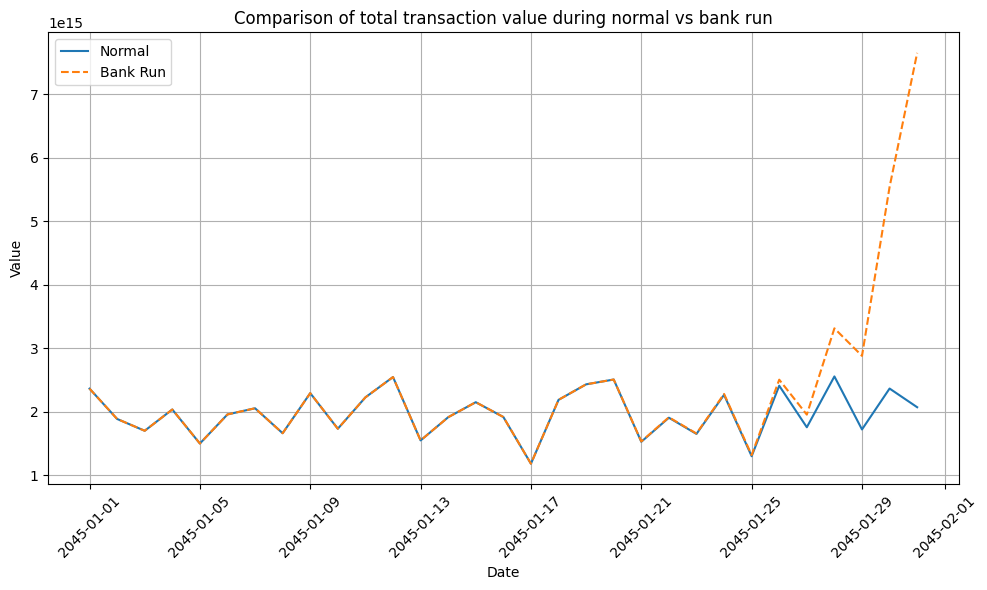

In [9]:
#Visualizing Bank Run

import matplotlib.pyplot as plt

# Converting 'Period' to datetime format
df_plot = df_with_bank_run.copy()
df_plot['Period'] = pd.to_datetime(df_plot['Period'])

# Grouping by date and summing up the values
df_plot['Date'] = df_plot['Period'].dt.date
df_plot = df_plot.groupby('Date').agg({'Value': 'sum', 'new_value': 'sum'}).reset_index()

# Plotting Value vs Bank Run Value
plt.figure(figsize=(10, 6))
plt.plot(df_plot['Date'], df_plot['Value'], label='Normal')
plt.plot(df_plot['Date'], df_plot['new_value'], label='Bank Run', linestyle='--')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of total transaction value during normal vs bank run')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

## Developing Anomaly Detection Model

In this section, we will continue to develop the anomaly detection model based on Autoencoder. The architecture is a simple one that implements encoder and decoder. The former functions as an extractor of important information based on input data to create a smaller representation, which can be called latent representation. The latter decompress the information to reconstruct the actual data. After training, the output of an Autoencoder model should share same similar values as the in input. The anomaly detection model works by looking at the reconstruction error, if it is high, there is a possibility something happen in the underlying data that might need for futher analysis. In this analysis, as we use simulated data, there is no need for that.

In this implementation, the input for the model is the flatenned version of a liquidity matrix, which means that it is a vector. Liquidity matrix, on the other hand, is the representation of payment transaction flow at a given period with the columns of the matrix are payment sender and the rows are the receiver. We normalized the liquidity matrix so that the values range from zero to one and transformed using log transformation, to give a more normal distribution. Both techniques are also used in (Triepels, Daniels & Heijmans, 2017).

We will examine the model itself, by comparing the input and output of the model, and then, observing the reconstruction error of the given data to identify whether the model could predict anomaly.

### Converting data into liquidity matrix

Initially, we want to extract the liqidity matrix for each time period. To do this, we need to get all unique periods and bank indentifications.

In [13]:
df = df_with_bank_run[['Period', 'Sender','Receiver', 'Counts']]
df["Value"] = df_with_bank_run["new_value"]

periods = np.unique(df["Period"].values)
all_banks = np.unique(df[['Sender', 'Receiver']].values)

C:\Users\hanzh\AppData\Local\Temp\ipykernel_9144\2580057910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Value"] = df_with_bank_run["new_value"]


Here we finally extract all liquidity matrix for each period, normalize the matrices, and perform log transform the the data. To be used in the model, we also convert it from `numpy.ndarray` representation into `torch.Tensor`.

In [15]:
def get_liquidity_matrix(df, all_banks):
    a_k_nom = pd.DataFrame(0, index=all_banks, columns=all_banks, dtype=float)

    for _, row in df.iterrows():
        a_k_nom.at[row["Sender"], row["Receiver"]] = row["Value"]

    return a_k_nom

A = []

normalized = True
transformed = True

for datetime in periods:
    a_k_nom = get_liquidity_matrix(df[df["Period"] == datetime], all_banks)
    a_k_nom = a_k_nom.values.flatten()
    if normalized:
        a_k_nom = (a_k_nom - a_k_nom.min()) / (a_k_nom.max() - a_k_nom.min())
    if transformed:
        a_k_nom = np.log1p(a_k_nom)
    A.append(np.concatenate([a_k_nom]))

A = np.array(A)
A = A.astype(np.float32)
A = torch.from_numpy(A)

As we would like to optimize the training and inference processes. We sent the input data or the liquidity matrices into the GPU. For anyone running this notebook without access to the GPU, this step will fall back to use the CPU.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A = A.to(device)
A

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1587, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3889,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2566,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

We split the training before crisis period happens. This is important so that the data from the bank run period is not used for training, so the model would recognize the changes as anomaly.

In [17]:
first_bank_run_index = df_with_bank_run["Period"].unique().searchsorted(pd.to_datetime("2045-01-21 07:00:00"))

X_train = A[:first_bank_run_index, :]
X_test = A[first_bank_run_index:, :]

### Autoencoder model definition

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, encoding_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)
        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.act_1(x)
        x = self.decoder(x)
        return x

This code will instantiate the Autoencoder model with 300 hidden encoding dimension. We choose the common `MSELoss` function for calculating losses and `Adam` optimizer for updating the model parameters.

In [19]:
model = Autoencoder(A.shape[1], 300)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

We also move the model training to the GPU as we did with the data.

In [20]:
model = model.to(device)

### Training Autoencoder model to recognize payment flow pattern

In this section, the model is trained using training data. 

In [21]:
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, X_train)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 0.0020
Epoch [2/500], Loss: 0.0019
Epoch [3/500], Loss: 0.0017
Epoch [4/500], Loss: 0.0016
Epoch [5/500], Loss: 0.0014
Epoch [6/500], Loss: 0.0013
Epoch [7/500], Loss: 0.0012
Epoch [8/500], Loss: 0.0011
Epoch [9/500], Loss: 0.0010
Epoch [10/500], Loss: 0.0009
Epoch [11/500], Loss: 0.0009
Epoch [12/500], Loss: 0.0009
Epoch [13/500], Loss: 0.0009
Epoch [14/500], Loss: 0.0009
Epoch [15/500], Loss: 0.0009
Epoch [16/500], Loss: 0.0009
Epoch [17/500], Loss: 0.0009
Epoch [18/500], Loss: 0.0009
Epoch [19/500], Loss: 0.0009
Epoch [20/500], Loss: 0.0009
Epoch [21/500], Loss: 0.0008
Epoch [22/500], Loss: 0.0008
Epoch [23/500], Loss: 0.0008
Epoch [24/500], Loss: 0.0008
Epoch [25/500], Loss: 0.0008
Epoch [26/500], Loss: 0.0008
Epoch [27/500], Loss: 0.0008
Epoch [28/500], Loss: 0.0008
Epoch [29/500], Loss: 0.0008
Epoch [30/500], Loss: 0.0008
Epoch [31/500], Loss: 0.0008
Epoch [32/500], Loss: 0.0008
Epoch [33/500], Loss: 0.0008
Epoch [34/500], Loss: 0.0008
Epoch [35/500], Loss: 0

The Autoencoder should be able to approximate the input. Here, a heat map is used to illustrate liquidity matrix. The higher of the value would result in darker area. We could observe from the plot below that the reconstructed liquidity matrix could reflect the given input.

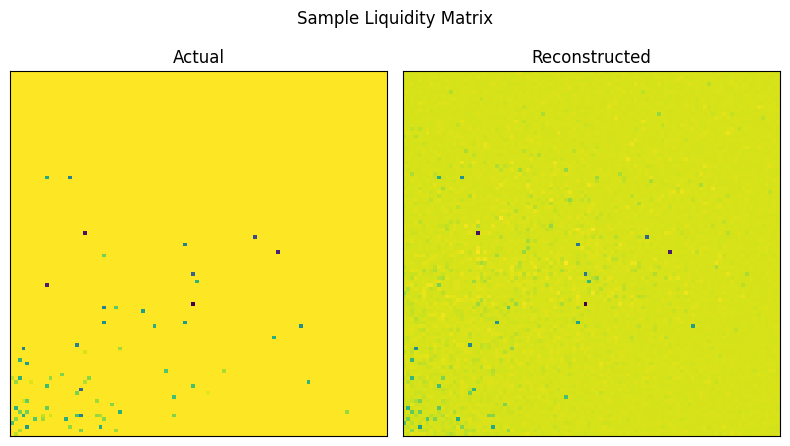

In [22]:
num_banks = len(all_banks)
period_id = 20

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

# Plot the first heatmap
cax1 = ax1.pcolormesh(X_test[period_id].reshape(num_banks, num_banks).detach().cpu(), cmap='viridis_r')
ax1.set_title('Actual')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the second heatmap
cax2 = ax2.pcolormesh(model(X_test)[period_id].reshape(num_banks, num_banks).detach().cpu(), cmap='viridis_r')
ax2.set_title('Reconstructed')
ax2.set_xticks([])
ax2.set_yticks([])

# Adjust layout to prevent overlap
plt.suptitle("Sample Liquidity Matrix")
plt.tight_layout()

# Show the plot
plt.show()  

### Evaluating model with simulated bank run

In this section, we examine if the model could detect anomaly based on the reconstruction error. We generate reconstruction errors from the beginning period which is also used for training, up to the last ten day period, or the bank run period.

In [ ]:
def calculate_reconstruction_error(original, reconstructed):
    return 0.5 * torch.sum((original - reconstructed) ** 2, dim=1)

model.eval()
with torch.no_grad():
    reconstructed_data = model(A)
    reconstruction_errors = calculate_reconstruction_error(A, reconstructed_data)
    reconstruction_errors = reconstruction_errors.cpu().numpy()

We then observed the reconstruction error using graph. We could see that during the bank run period, there is an increase in the errors. **This shows that the model could detect anomaly period when the bank run was simulated**.

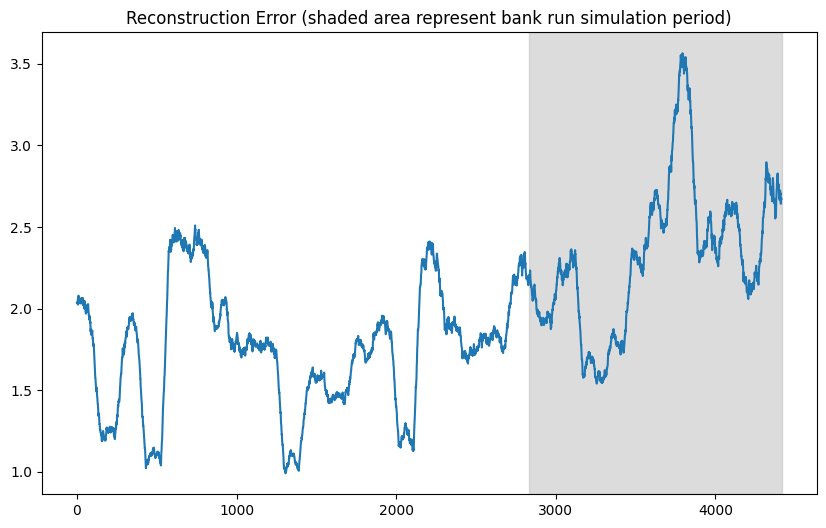

In [ ]:
# Visualization of Errors
def visualize_errors(errors, smooth_window_size = 50):
    window = np.ones(smooth_window_size) / smooth_window_size
    moving_average = np.convolve(errors, window, 'valid')

    plt.figure(figsize=(10, 6))
    plt.axvspan(first_bank_run_index - smooth_window_size, len(moving_average) - 1, color='#bbbbbb', alpha=0.5)
    plt.plot(moving_average, label='Reconstruction Error')
    plt.title('Reconstruction Error (shaded area represent bank run simulation period)')
    plt.show()

visualize_errors(reconstruction_errors)

## Reference

- Soramäki, K. and Cook, S., 2013. SinkRank: An algorithm for identifying systemically important banks in payment systems. Economics: The Open-Access, Open-Assessment E-Journal, [online] Vol. 7, Iss. 2013-28, pp.1-27. Available at: https://doi.org/10.5018/economics-ejournal.ja.2013-28 [6 Juni 2024].

- Triepels, R., Daniels, H. and Heijmans, R., 2017. Anomaly Detection in Real-Time Gross Settlement Systems. In: Proceedings of the 19th International Conference on Enterprise Information Systems - Volume 1: ICEIS. [online] INSTICC, SciTePress, pp.433-441. Available at: https://doi.org/10.5220/0006333004330441 [6 Juni 2024].